# Esclarecimentos

**O que é isso?**  
O conteúdo deste notebook é parte de um teste de data science proposta pelo [Elo7](https://www.elo7.com.br/) e pode servir para quem se interessar por [sistemas de recomendação](https://en.wikipedia.org/wiki/Recommender_system), [machine learning](https://en.wikipedia.org/wiki/Machine_learning), [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) ou o dataset [MovieLens](https://grouplens.org/datasets/movielens/)

**Público**  
Este notebook está sendo preparado como se fosse apresentado para alguém que possui familiaridade com ciência de dados e não como forma de apresentação final dos resultados para uma comissão de leigos.

**Objetivos**  
-  A partir do dataset MovieLens extrair dados relevantes que possam ser utilizados para construir um sistema de recomendação;
-  Construir um sistema de recomendação de filmes, utilizando o dataset MovieLens, a partir do input do Id de um usuário;
-  Determinar uma métrica para avaliar a performance do sistema criado.

# Parte 1 - Análise Exploratória

## Verificando a estrutura dos dados

A base de dados possui 6 arquivos identificados como "genome_scores.csv", "genome_tags.csv", "links.csv", "movies.csv", "ratings.csv" e "tags.csv". Inicialmente vamos apenas verificar o conteúdo dos arquivos (com a biblioteca pandas) e da documentação [[Documentação: MovieLens](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)]. Após a primeira análise vamos poder criar algumas hipóteses.

In [1]:
# bibliotecas iniciais
import pandas as pd              # manipulação e listagem de dados
import numpy as np               # algebra
import matplotlib.pyplot as plt  # gráficos
import seaborn as sns            # gráficos

In [2]:
# desativar mensagens sobre bibliotecas que serão descontinuadas em breve
import warnings
warnings.filterwarnings('ignore',category=DeprecationWarning)

In [5]:
# importando os arquivos
dt_gen_scores = pd.read_csv(r"ml-20m/genome-scores.csv")
dt_gen_tags = pd.read_csv(r"ml-20m/genome-tags.csv")
dt_links = pd.read_csv(r"ml-20m/links.csv")
dt_movies = pd.read_csv(r"ml-20m/movies.csv")
dt_ratings = pd.read_csv(r"ml-20m/ratings.csv")
dt_tags = pd.read_csv(r"ml-20m/tags.csv")

Definimos uma pequena função para mostrar algumas características básicas dos dataframes.

In [6]:
def summary(dataframe):
    print("head: \n")
    print(dataframe.head(),"\n")
    print("info: \n")
    print(dataframe.info(),"\n")
    print("describe: \n")
    print(dataframe.describe(),"\n")
    print("isnull: \n")
    print(dataframe.isnull().sum(),"\n")
    print("shape: \n")
    print(dataframe.shape,"\n")

### Dataframes: dt_genome_scores e dt_genome_tags

In [7]:
summary(dt_gen_scores)

head: 

   movieId  tagId  relevance
0        1      1    0.02500
1        1      2    0.02500
2        1      3    0.05775
3        1      4    0.09675
4        1      5    0.14675 

info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
movieId      int64
tagId        int64
relevance    float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB
None 

describe: 

            movieId         tagId     relevance
count  1.170977e+07  1.170977e+07  1.170977e+07
mean   2.584297e+04  5.645000e+02  1.164833e-01
std    3.467615e+04  3.256254e+02  1.542463e-01
min    1.000000e+00  1.000000e+00  2.500000e-04
25%    2.926000e+03  2.827500e+02  2.425000e-02
50%    6.017000e+03  5.645000e+02  5.650000e-02
75%    4.606200e+04  8.462500e+02  1.415000e-01
max    1.311700e+05  1.128000e+03  1.000000e+00 

isnull: 

movieId      0
tagId        0
relevance    0
dtype: int64 

shape: 

(11709768, 3) 



In [8]:
summary(dt_gen_tags)

head: 

   tagId           tag
0      1           007
1      2  007 (series)
2      3  18th century
3      4         1920s
4      5         1930s 

info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
tagId    1128 non-null int64
tag      1128 non-null object
dtypes: int64(1), object(1)
memory usage: 17.7+ KB
None 

describe: 

             tagId
count  1128.000000
mean    564.500000
std     325.769857
min       1.000000
25%     282.750000
50%     564.500000
75%     846.250000
max    1128.000000 

isnull: 

tagId    0
tag      0
dtype: int64 

shape: 

(1128, 2) 



Da documentação temos que:
'''The tag genome is a data structure that contains tag relevance scores for movies. The structure is a dense matrix: each
movie in the genome has a value for every tag in the genome.
As described in this article, the tag genome encodes how strongly movies exhibit particular properties represented by tags
(atmospheric, thought-provoking, realistic, etc.). The tag genome was computed using a machine learning algorithm on 
user-contributed content including tags, ratings, and textual reviews.'''

Existem 1128 tags e portanto cada filme possui 1128 valores de relevance Aparentemente temos algumas tags diferentes como *strings* e iguais no contexto:

In [9]:
# verificando algumas possíveis tags repetidas
print(dt_gen_tags[dt_gen_tags['tag'].str.contains('007')],"\n")
print(dt_gen_tags[dt_gen_tags['tag'].str.contains('19')])

   tagId           tag
0      1           007
1      2  007 (series) 

   tagId           tag
3      4         1920s
4      5         1930s
5      6         1950s
6      7         1960s
7      8         1970s
8      9         1980s
9     10  19th century


Inicialmente não vemos um problema nessas tags "repetidas", já que ainda não sabemos quantas repetem.

### Dataframe: dt_links

In [10]:
dt_links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


Essas Ids permitem que busquemos mais informações sobre os filmes nas databases: [Internet Movie Databse](https://www.imdb.com/) e [The Movie Database](https://www.themoviedb.org/). Informações estas que serão discutidas na seção Conclusão.

### Dataframe: dt_movies

In [11]:
dt_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [12]:
dt_movies.shape

(27278, 3)

A base de dados possui 27278 filmes diferentes aqui identificados por 'movieId', possuindo título e os gêneros de filmes nos quais são classificados.

### Dataframe: dt_ratings

In [13]:
dt_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [14]:
dt_ratings.shape

(20000263, 4)

In [15]:
# numero de usuários
dt_ratings['userId'].max()

138493

In [16]:
# média de avaliações por usuário
len(dt_ratings['userId'])/dt_ratings['userId'].max()

144.4135299257002

In [17]:
# número mínimo de avalições feitas por usuários
dt_ratings.groupby('userId').count().min()

movieId      20
rating       20
timestamp    20
dtype: int64

In [18]:
# número máximo de avalições feitas por usuários
dt_ratings.groupby('userId').count().max()

movieId      9254
rating       9254
timestamp    9254
dtype: int64

In [19]:
# maior numero de avaliações que um filme recebeu
dt_ratings.groupby('movieId').count().max()

userId       67310
rating       67310
timestamp    67310
dtype: int64

In [20]:
# menor numero de avaliações que um filme recebeu
dt_ratings.groupby('movieId').count().min()

userId       1
rating       1
timestamp    1
dtype: int64

In [21]:
# número de filmes avaliados apenas uma vez
pd.DataFrame(dt_ratings.groupby(['movieId']).count()['userId']==1).sum()

userId    3972
dtype: int64

São mais de 20 milhões de avaliações dos quase 140 mil usuários, em média cada usuário avaliou 144 filmes. O máximo de avaliações feitas por um usuário foi 9254 e o mínimo 20 (como descreve a documentação). Dos 27278 filmes, 3972 foram avaliados apenas uma vez. Seria ideal utilizar todo este espaço amostral para a análise, porém há limitações de hardware e vamos optar por utilizar cerca de 5% dos usuários apenas.

In [22]:
# 3500 usuários é pouco menos de 5%
dt_ratings = dt_ratings[dt_ratings['userId']<=3500]
dt_ratings.shape

(517084, 4)

Ficamos então com 517084 avaliações para serem utilizadas.

**Dataframe: dt_tags**

Da documentação temos que: "Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user."

In [23]:
dt_tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078


In [24]:
dt_tags.shape

(465564, 4)

In [25]:
len(set(dt_tags['tag']))

38644

Temos aqui tags dadas por usuários para determinado filme, no total são 465564 tags e dessas 38644 são únicas. Pode ainda haver iguais em contexto, mas possuem a escrita diferente. Este tipo de informação pode ser muito útil no caso do sistema de recomendação personalizado. No caso de um sistema baseado nas características dos filmes deve-se ter cuidado, pois as tags podem ser bem pessoais.

### Após uma pré-análise

Dentre os possíveis caminhos para construir o sistema de recomendação foi decidido que os dataframes "dt_gen_scores", "dt_gen_tags", "dt_links" e "dt_tags" não serão usados. A ideia é construir um sistema baseado nas características dos filmes não envolvendo as tags, já que seria necessária uma análise de Natural Language Processing tomando mais tempo.

In [26]:
# apagando os datasets que não serão mais usados
del dt_gen_scores, dt_gen_tags, dt_links, dt_tags

## Perguntas

Após a primeira verificação dos dados decidiu-se focar nos dados contidos nos dataframes "dt_movies" e "dt_ratings", dos quais é possível obter características dos filmes. A partir destes haverá uma etapa de análise e feature engineering com o objetivo de responder as perguntas a seguir:  

-  Como as avaliações são distribuídas?
-  Quantas avaliações em média tem um filme?
-  Qual o número de vezes mínimo significativo que um filme foi avaliado?
-  Existe alguma relação entre o gênero do filme e o padrão de avaliação dos usuários?  
-  Existe correlação entre os gêneros de filme?
-  Usuários que gostam de um gênero também gostam de outro(s)?
-  O ano de lançamento do filme influencia na avaliação?
-  A hora do dia influencia na avaliação que o usuário dá para um filme?
-  Existe correlação entre variedade de gênero de um filme e sua avaliação?

### Feature engineering

**Dataframe: dt_movies**
Este dataset apresenta duas características que podem ser usadas como variáveis separadas: em "title" podemos separar o título do filme em título e ano; o gênero é interessante separar em uma matriz esparsa binária (1 se o filme possui o gênero e 0 caso contrário).
Para extrair o ano de lançamento do filme **vamos assumir** que este é informado como uma sequência de 4 números na coluna que contém o título.

##### Obtendo o ano de lançamento dos filmes

In [27]:
# coluna para o ano de lançamento
dt_movies['release_date'] = dt_movies['title'].str.extract('(\d{4})')
dt_movies['release_date'] = pd.to_numeric(dt_movies['release_date'],errors='coerce',downcast='integer')
dt_movies.head()

,movieId,title,genres,release_date
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995.0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995.0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995.0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995.0
4,5,Father of the Bride Part II (1995),Comedy,1995.0


Devemos verificar se todos os filmes possuem o ano de lançamento informado como assumimos.

In [28]:
# dados faltando
dt_movies['release_date'].isnull().sum()

19

In [29]:
# ano de lançamento máximo
dt_movies['release_date'].max()

9500.0

In [30]:
# ano de lançamento mínimo
dt_movies['release_date'].min()

1000.0

Há 19 filmes que não possuem uma sequência de 4 dígitos seguidos no título. Assumiremos que o ano de lançamento não foi informado. Em princípio não parece haver necessidade de tirar o ano do título do filme. Há também filmes que possuem quatro dígitos seguidos no título (ex: Detroit 9000), resultando em anos maiores que 2018 (os dados do dataset vão até 2016) e também anteriores ao século 19. Como o número é pequeno vamos colocar os anos corretos "manualmente".

In [31]:
# filmes que possuem 'release_date' maior que 2018
print(dt_movies[dt_movies['release_date']>2018])

       movieId                                              title  \
662        671     Mystery Science Theater 3000: The Movie (1996)   
2223      2308                                Detroit 9000 (1973)   
4065      4159                     3000 Miles to Graceland (2001)   
5213      5310                         Transylvania 6-5000 (1985)   
8181      8864                                    Mr. 3000 (2004)   
9255     27266                                        2046 (2004)   
9494     27800  Interstella 5555: The 5tory of the 5ecret 5tar...   
16724    84551                                   44500 Max (2009)   
18047    90460            2019: After the Fall of New York (1983)   
18286    91421                               Red Line 7000 (1965)   
18578    92477                              Yes: 9012 Live (1985)   
19660    97242           Daleks' Invasion Earth: 2150 A.D. (1966)   
19844    98019      Vexille (Bekushiru: 2077 Nihon sakoku) (2007)   
20663   101237                    

In [32]:
# índices dos filmes
rel_date_indices = dt_movies.index[dt_movies['release_date']>2018]
# sequência de 4 dígitos final de cada filme
rel_date_values = dt_movies['title'][rel_date_indices].str[-5:-1]

In [33]:
# colocando os valores corretos
dt_movies['release_date'][rel_date_indices] =  rel_date_values.values

/home/ninja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [34]:
# verificamos se os valores são os mesmos
dt_movies['release_date'][rel_date_indices]

662      1996
2223     1973
4065     2001
5213     1985
8181     2004
9255     2004
9494     2003
16724    2009
18047    1983
18286    1965
18578    1985
19660    1966
19844    2007
20663    2009
21050    2002
21077    2013
21630    2012
22741    1984
22854    2008
23501    2014
23816    1986
24020    2009
Name: release_date, dtype: object

In [35]:
# ano de lançamento mínimo
dt_movies['release_date'] = pd.to_numeric(dt_movies['release_date'],errors='coerce',downcast='integer')
dt_movies['release_date'].min()

1000.0

In [36]:
dt_movies.sort_values(by='release_date')[:26]

,movieId,title,genres,release_date
6191,6290,House of 1000 Corpses (2003),Horror,1000.0
26429,126999,1000 Journals (2007),(no genres listed),1000.0
7695,8198,"1000 Eyes of Dr. Mabuse, The (Die 1000 Augen d...",Crime|Horror|Mystery|Thriller,1000.0
22287,107155,Captive Women (1000 Years from Now) (3000 A.D....,Sci-Fi,1000.0
24204,114721,Bugs Bunny's 3rd Movie: 1001 Rabbit Tales (1982),Adventure|Animation|Children|Comedy,1001.0
26279,126164,1001 Nights (1990),Adventure|Comedy|Fantasy,1001.0
14768,73862,Note by Note: The Making of Steinway L1037 (2007),Documentary,1037.0
14878,74491,1066 (2009),Action|Adventure|War,1066.0
13750,68874,"Jeanne Dielman, 23 Quai du Commerce, 1080 Brux...",Drama,1080.0
16103,81453,Dial 1119 (1950),Crime|Drama|Film-Noir,1119.0


Consideremos que o filme mais antigo é de 1891.

In [37]:
print(dt_movies[dt_movies['release_date']<1891])

       movieId                                              title  \
1388      1422                              Murder at 1600 (1997)   
4216      4311  Bloody Angels (1732 Høtten: Marerittet har et ...   
5375      5472                                        1776 (1972)   
6191      6290                       House of 1000 Corpses (2003)   
6535      6645                                    THX 1138 (1971)   
7695      8198  1000 Eyes of Dr. Mabuse, The (Die 1000 Augen d...   
8222      8905                  1492: Conquest of Paradise (1992)   
11964    53953                                        1408 (2007)   
13750    68874  Jeanne Dielman, 23 Quai du Commerce, 1080 Brux...   
14768    73862  Note by Note: The Making of Steinway L1037 (2007)   
14878    74491                                        1066 (2009)   
14922    74706                   Commune, La (Paris, 1871) (2000)   
16103    81453                                   Dial 1119 (1950)   
17116    86637             1612: K

Repetimos o procedimento anterior.

In [38]:
rel_date_indices_min = dt_movies.index[dt_movies['release_date']<1891]
rel_date_values_min = dt_movies['title'][rel_date_indices_min].str[-5:-1]
dt_movies['release_date'][rel_date_indices_min] =  rel_date_values_min.values
dt_movies['release_date'][rel_date_indices_min]

/home/ninja/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


1388     1997
4216     1998
5375     1972
6191     2003
6535     1971
7695     1960
8222     1992
11964    2007
13750    1975
14768    2007
14878    2009
14922    2000
16103    1950
17116    2007
21163    2008
21515    2010
22287    1952
22922    2007
22923    2012
23297    2012
24204    1982
24537    1967
26279    1990
26429    2007
Name: release_date, dtype: object

In [39]:
# verificamos novamente
dt_movies['release_date'] = pd.to_numeric(dt_movies['release_date'],errors='coerce',downcast='integer')
print(dt_movies['release_date'].max())
print(dt_movies['release_date'].min())

2016.0
1891.0


In [40]:
# apagando variáveis desnecessárias
del rel_date_indices, rel_date_values, rel_date_indices_min, rel_date_values_min

##### Obtendo a matriz dos gêneros

Para escrever a matriz dos gêneros separamos cada gênero informado pelo delimitador "|" e adicionamos o prefixo "gen:" para evitar uma possível confusão.

In [41]:
movies_gen = pd.get_dummies(dt_movies['genres'].str.split('|',expand=True).stack()).sum(level=0).add_prefix('gen:')
movies_gen.head()

,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,gen:Documentary,gen:Drama,gen:Fantasy,gen:Film-Noir,gen:Horror,gen:IMAX,gen:Musical,gen:Mystery,gen:Romance,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [42]:
movies_gen.shape

(27278, 20)

Uma variável que pode ser útil é o número de gêneros que um filme possui. É comum fazer filmes muito genéricos para atingir um público maior, veremos se isso influencia na avaliação do usuário.

In [43]:
# coluna para o número de gêneros os gêneros
movies_gen['num_gen'] = movies_gen.sum(axis=1)
movies_gen.head()

,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,gen:Documentary,gen:Drama,gen:Fantasy,...,gen:Horror,gen:IMAX,gen:Musical,gen:Mystery,gen:Romance,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western,num_gen
0,0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5
1,0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,3
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Neste dataframe não há repetição de filmes e podemos contar quantas vezes cada gênero aparece.

In [44]:
# nomes das colunas que contém o gênero
gen_cols = ['gen:(no genres listed)','gen:Action','gen:Adventure','gen:Animation','gen:Children','gen:Comedy','gen:Crime',
            'gen:Documentary','gen:Drama','gen:Fantasy','gen:Film-Noir','gen:Horror','gen:IMAX','gen:Musical','gen:Mystery',
            'gen:Romance', 'gen:Sci-Fi','gen:Thriller','gen:War','gen:Western']

In [45]:
movies_gen_freq = movies_gen[gen_cols].sum()
movies_gen_freq

gen:(no genres listed)      246
gen:Action                 3520
gen:Adventure              2329
gen:Animation              1027
gen:Children               1139
gen:Comedy                 8374
gen:Crime                  2939
gen:Documentary            2471
gen:Drama                 13344
gen:Fantasy                1412
gen:Film-Noir               330
gen:Horror                 2611
gen:IMAX                    196
gen:Musical                1036
gen:Mystery                1514
gen:Romance                4127
gen:Sci-Fi                 1743
gen:Thriller               4178
gen:War                    1194
gen:Western                 676
dtype: int64

In [46]:
# concatenamos "dt_movies" com "movies_gen".
dt_movies = pd.concat([dt_movies, movies_gen], axis=1)
dt_movies.sample(5)

,movieId,title,genres,release_date,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,...,gen:Horror,gen:IMAX,gen:Musical,gen:Mystery,gen:Romance,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western,num_gen
993,1012,Old Yeller (1957),Children|Drama,1957.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,2
12773,60225,Tell It to the Marines (1926),Comedy|Drama|Romance|War,1926.0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,1,0,4
20039,98788,Stand Up and Fight (1939),Drama|Romance|Western,1939.0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,3
24456,115871,Mercy (2014),Horror|Thriller,2014.0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,2
9933,32562,Harvie Krumpet (2003),Animation|Comedy|Drama,2003.0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,3


In [47]:
# descartamos a coluna 'genres'
dt_movies = dt_movies.drop('genres',axis=1)
dt_movies.shape

(27278, 24)

In [48]:
# movies_gen não é mais necessário
del movies_gen

**Dataframe: dt_ratings**  
Um fator que pode ser importante em uma recomendação é o horário em que ela foi feita. No fim de um dia usualmente estamos mais cansados e portanto somos menos criteriosos ao dar uma nota [Promessas | Nerdologia](https://www.youtube.com/watch?v=EVcJCly8rBY&index=14&list=PLyRcl7Q37-DUKZL1fxMb1uNX9IrpX2rjg). Assim transformamos 'timestamp' em categorias de 0 a 23 para as horas.

##### Hora em que a avaliação foi feita

In [49]:
dt_ratings['hour'] = (dt_ratings['timestamp'] // 3600) % 24
dt_ratings.head(10)

,userId,movieId,rating,timestamp,hour
0,1,2,3.5,1112486027,23
1,1,29,3.5,1112484676,23
2,1,32,3.5,1112484819,23
3,1,47,3.5,1112484727,23
4,1,50,3.5,1112484580,23
5,1,112,3.5,1094785740,3
6,1,151,4.0,1094785734,3
7,1,223,4.0,1112485573,23
8,1,253,4.0,1112484940,23
9,1,260,4.0,1112484826,23


In [50]:
# verificando
print(dt_ratings['hour'].max())
print(dt_ratings['hour'].min())
print(dt_ratings['hour'].mean())
print(dt_ratings['hour'].std())

23
0
12.485919115656257
7.317289933681305


##### Avaliação média de cada usuário e filme

Outra característica que pode ser interessante é a avaliação média de cada usuário e de cada filme.

In [51]:
# rating médio por usuario (RMPU)
RMPU = dt_ratings.groupby(['userId']).mean().reset_index()
RMPU['mean_rat_user'] = RMPU['rating']
RMPU = RMPU[['userId','mean_rat_user']].copy()
# rating médio por filme (RMPM)
RMPM = dt_ratings.groupby(['movieId']).mean().reset_index()
RMPM['mean_rat_movie'] = RMPM['rating']
RMPM = RMPM[['movieId','mean_rat_movie']].copy()

dt_ratings.head()

,userId,movieId,rating,timestamp,hour
0,1,2,3.5,1112486027,23
1,1,29,3.5,1112484676,23
2,1,32,3.5,1112484819,23
3,1,47,3.5,1112484727,23
4,1,50,3.5,1112484580,23


Agora vamos unir os dataframes de acordo com a variável em comum "movieId".

In [52]:
dt_ratings = pd.merge(dt_ratings,RMPU,on=['userId','userId'])
dt_ratings = pd.merge(dt_ratings,RMPM,on=['movieId','movieId'])

In [53]:
data = pd.merge(dt_movies,dt_ratings,on=['movieId','movieId'])
data.head()

,movieId,title,release_date,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,...,gen:Thriller,gen:War,gen:Western,num_gen,userId,rating,timestamp,hour,mean_rat_user,mean_rat_movie
0,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,5,3,4.0,944919407,13,4.122995,3.970998
1,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,5,6,5.0,858275452,17,3.750000,3.970998
2,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,5,8,4.0,833981871,13,3.800000,3.970998
3,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,5,10,4.0,943497887,2,3.894737,3.970998
4,1,Toy Story (1995),1995.0,0,0,1,1,1,1,0,...,0,0,0,5,11,4.5,1230858821,1,3.945437,3.970998


In [54]:
# não utilizaremos mais 'timestamp'
data = data.drop('timestamp',axis=1)
data.shape

(517084, 29)

Atualmente o Netflix não utiliza a avaliação na escala de 5 estrelas e sim apenas como: positiva ou negativa. Poderíamos fazer o mesmo aqui considerando que uma avaliação positiva é aquela acima da média do usuário e negativa abaixo. Entretanto, podemos ter problemas: por exemplo, um usuário que avalia muito com a nota cinco poderia ter a nota 4 considerada como um "dislike" e isso possivelmente estaria errado. Assim, escolhemos seguir com a escala atual.

In [55]:
# salvando o dataset para futura análise e apagando a variável por hora
#dt_ratings = dt_ratings.drop(['timestamp'],axis=1)
#dt_ratings.to_csv(r'ratings_new.csv',index=False)
del dt_ratings, RMPU, RMPM

### Análise:  

A partir de agora vamos utilizar os dados do dataframe "data" para responder as perguntas propostas e posteriormente construir o sistema de recomendação.

#### Como as avaliações são distribuídas?

Text(0.5, 0, 'Avaliação')

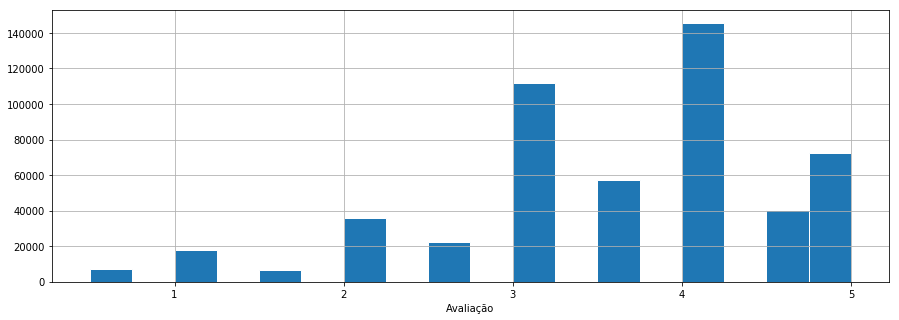

In [56]:
# número de classes para os histogramas
k = 1+int(1.33*np.log(len(data['mean_rat_movie'])))

data['rating'].hist(edgecolor='w', figsize=(15,5), bins=k);
plt.xlabel('Avaliação')

In [57]:
print('Média:{:.2f}'.format(data['rating'].mean()))
print('Desvio padrão:{:.2f}'.format(data['rating'].std()))
print('Mediana:{:.2f}'.format(data['rating'].median()))
print('Moda:',data['rating'].mode())

Média:3.52
Desvio padrão:1.05
Mediana:3.50
Moda: 0    4.0
dtype: float64


O número de avaliações entre 0 e 2.5 é pequeno se comparado ao de 3 ou mais. Várias podem ser as razões disso: (i) os usuários já têm uma ideia inicial do filme e fazem um próprio filtro sendo surpreendidas com filmes que não gostam poucas vezes; (ii) usuários procuram defender os filmes que gostam, avaliando os mesmos, e não se importam muito com os que não gostam, os deixando sem avaliação; (iii) os filmes podem já ter sido recomendados por pessoas ou mesmo um sistema de avaliação.

Poderíamos pensar em diversos motivos para isso, mas são apenas hipóteses não testadas. Para resultados concretos um estudo grande deve ser feito sobre como as avaliações e a mineração dos dados foram realizadas.

Text(0.5, 0, 'Avaliação média dos usuários')

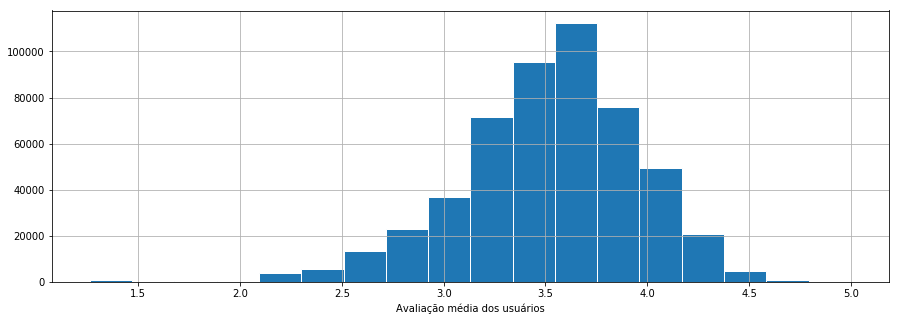

In [58]:
data['mean_rat_user'].hist(edgecolor='w', figsize=(15,5), bins=k);
plt.xlabel('Avaliação média dos usuários')

In [59]:
print('Média:{:.2f}'.format(data['mean_rat_user'].mean()))
print('Desvio padrão:{:.2f}'.format(data['mean_rat_user'].std()))
print('Mediana:{:.2f}'.format(data['mean_rat_user'].median()))
print('Moda:',data['mean_rat_user'].mode())

Média:3.52
Desvio padrão:0.44
Mediana:3.55
Moda: 0    2.710855
dtype: float64


In [60]:
print(data['mean_rat_user'].skew())
print(data['mean_rat_user'].kurtosis())

-0.6098922421392832
1.2894303611162998


Podemos observar que a distribuição das avaliações é bem próxima de uma distribuição normal. Este pode ter sido um dos fatores que o Netflix mudar seu sistema de avaliação.

Text(0.5, 0, 'Avaliação média dos filmes')

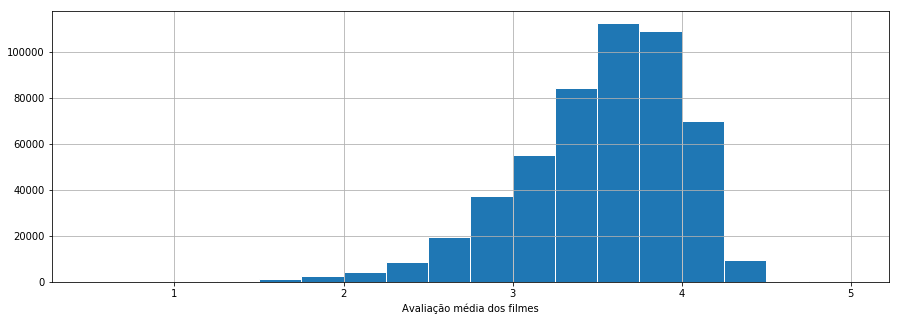

In [61]:
data['mean_rat_movie'].hist(edgecolor='w', figsize=(15,5), bins=k);
plt.xlabel('Avaliação média dos filmes')

In [62]:
print('Média:{:.2f}'.format(data['mean_rat_movie'].mean()))
print('Desvio padrão:{:.2f}'.format(data['mean_rat_movie'].std()))
print('Mediana:{:.2f}'.format(data['mean_rat_movie'].median()))
print('Moda:',data['mean_rat_movie'].mode())

Média:3.52
Desvio padrão:0.50
Mediana:3.60
Moda: 0    3.5
dtype: float64


In [63]:
print(data['mean_rat_movie'].skew())
print(data['mean_rat_movie'].kurtosis())

-1.0282920552153105
1.8817094498449984


A distribuição das avaliações médias dos filmes é um pouco menos simétrica, mas ainda pode-se aproximar para uma normal.

#### Quantas avaliações em média tem um filme? Qual o número de vezes mínimo significativo que um filme foi avaliado?

O número de vezes que um filme foi avaliado é importante para um modelo estatístico, por exemplo, um filme que só foi avaliado uma vez e obteve boa avaliação pode ser erroneamente sugerido ao usuário no lugar de um com avaliação mediana e muitas avaliações. Vamos então contar quantas vezes cada filme foi avaliado.

In [64]:
data.groupby('movieId').count()[:5]

,title,release_date,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,gen:Documentary,...,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western,num_gen,userId,rating,hour,mean_rat_user,mean_rat_movie
movieId,,,,,,,,,,,,,,,,,,,,,
1,1293,1293,1293,1293,1293,1293,1293,1293,1293,1293,...,1293,1293,1293,1293,1293,1293,1293,1293,1293,1293
2,569,569,569,569,569,569,569,569,569,569,...,569,569,569,569,569,569,569,569,569,569
3,324,324,324,324,324,324,324,324,324,324,...,324,324,324,324,324,324,324,324,324,324
4,59,59,59,59,59,59,59,59,59,59,...,59,59,59,59,59,59,59,59,59,59
5,336,336,336,336,336,336,336,336,336,336,...,336,336,336,336,336,336,336,336,336,336


In [65]:
freq_count = data.groupby(['movieId']).count()

In [66]:
freq_count['title'].head()

movieId
1    1293
2     569
3     324
4      59
5     336
Name: title, dtype: int64

In [67]:
print("Número máximo de avaliações:",freq_count['title'].max())
print("Número mínimo de avaliações:",freq_count['title'].min())
print("Número total de avaliações:",freq_count['title'].sum())
print("Número médio de avaliações:{:.2f}".format(freq_count['title'].mean()))
print("Desvio padrão do número médio de avaliações:{:.2f}".format(freq_count['title'].std()))

Número máximo de avaliações: 1751
Número mínimo de avaliações: 1
Número total de avaliações: 517084
Número médio de avaliações:41.92
Desvio padrão do número médio de avaliações:113.83


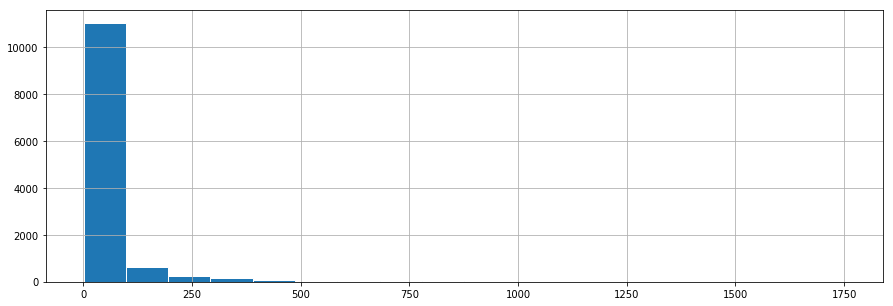

In [68]:
freq_count['title'].hist(edgecolor='w', bins=k,figsize=(15,5));

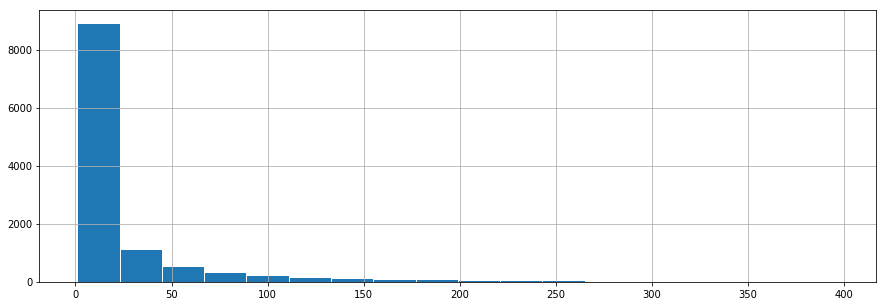

In [69]:
freq_count['title'][freq_count['title']<400].hist(edgecolor='w', bins=k,figsize=(15,5));

Essa distribuição claramente não é gaussiana, de acordo com o significado dos dados, esta poderia se adequar a uma distribuição de Poisson, já que um filme tem maior chance de ser assistido com o passar do tempo (se os dados vierem de um sistema de recomendação essa estatística pode ser alterada). Um teste $\chi^{2}$ poderia ser utilizado para confirmar ou não se a distribuição é de Poisson, entretanto não utilizaremos isso aqui para que a análise seja mais rápida. Em seguida vamos utilizar a correlação de Pearson e para tal é usual considerar o número mínimo significativo de observações sendo 25, ou seja, um filme com 25 avaliações já pode ser considerado em nossa estatística.

#### Existe alguma relação entre o gênero do filme e o padrão de avaliação dos usuários?

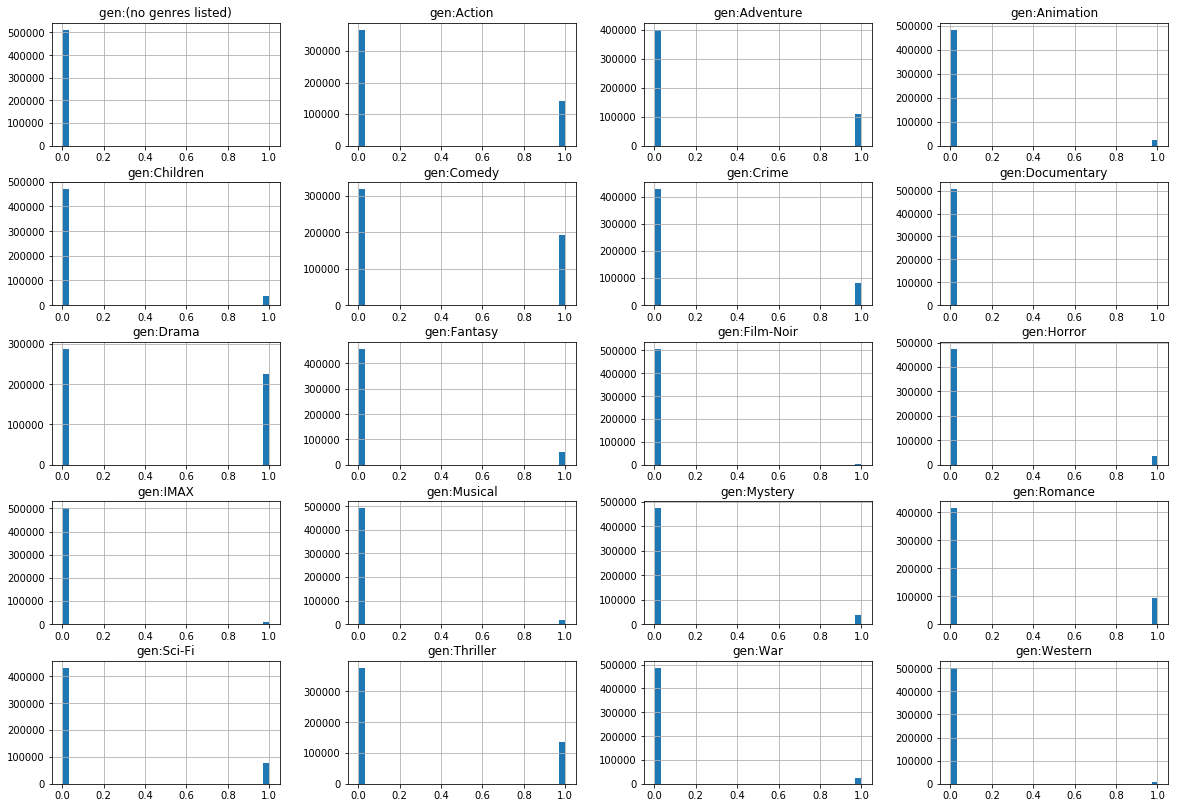

In [70]:
data[gen_cols].hist(bins=30, figsize=(20,14),edgecolor='w');

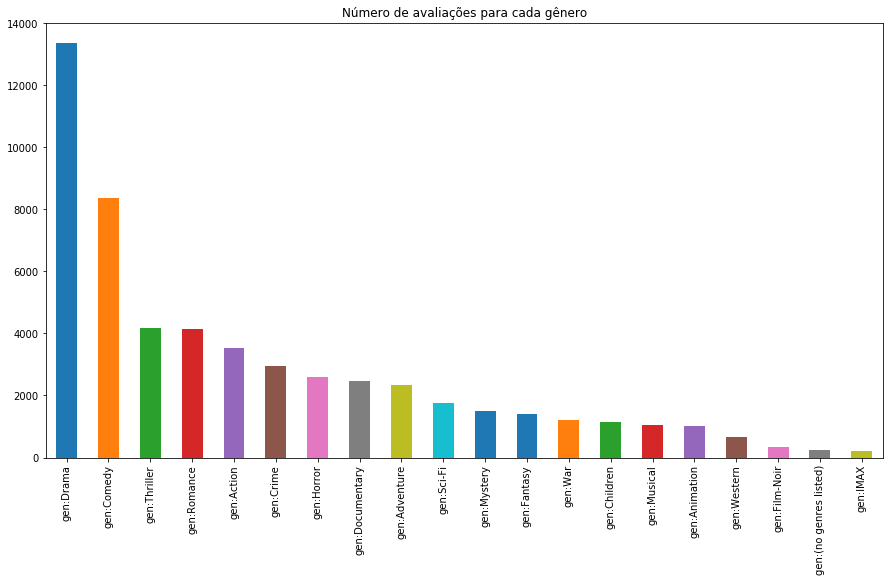

In [71]:
# contagem de gêneros: calculado anteriormente
plt.figure(figsize=(15,8))
plt.title('Número de avaliações para cada gênero')
movies_gen_freq.sort_values(ascending=False).plot.bar();

In [72]:
n_crit = 25
corr_pearson = data.corr(method='pearson',min_periods=n_crit)

In [73]:
# calculamos a correlação de Spearman para o caso de uma possível não linearidade
corr_spearman = data.corr(method='spearman',min_periods=n_crit)

In [74]:
print(corr_pearson.shape)
print(corr_spearman.shape)

(28, 28)
(28, 28)


In [75]:
corr_pearson.head()

,movieId,release_date,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,gen:Documentary,...,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western,num_gen,userId,rating,hour,mean_rat_user,mean_rat_movie
movieId,1.000000,0.379795,0.012208,0.045970,0.016972,0.044988,-0.013147,-0.043462,0.019867,0.062718,...,0.038479,0.028382,-0.009994,-0.017892,0.088686,0.016272,0.000675,-0.015962,0.005569,0.001421
release_date,0.379795,1.000000,0.002996,0.105445,0.022544,-0.002355,-0.053920,0.053602,0.049682,0.049917,...,0.039353,0.110608,-0.075871,-0.076820,0.071607,0.013297,-0.099745,-0.004575,-0.037544,-0.210139
gen:(no genres listed),0.012208,0.002996,1.000000,-0.001232,-0.001044,-0.000478,-0.000591,-0.001536,-0.000873,-0.000216,...,-0.000856,-0.001185,-0.000457,-0.000292,-0.002812,0.000256,0.000432,0.000676,0.001458,0.000911
gen:Action,0.045970,0.105445,-0.001232,1.000000,0.330866,-0.100106,-0.142678,-0.236511,0.096602,-0.064966,...,0.309599,0.272789,0.062011,0.032073,0.389909,-0.000032,-0.042399,0.004990,0.002774,-0.089323
gen:Adventure,0.016972,0.022544,-0.001044,0.330866,1.000000,0.222515,0.224056,-0.068900,-0.173130,-0.054286,...,0.236649,-0.038794,-0.047615,0.044065,0.426767,0.003563,-0.007464,-0.001755,0.019276,-0.015726


Para eliminar os filmes com menos de 25 avaliações fazemos:

In [76]:
freq_min = freq_count[freq_count['title']<=n_crit].index.values
print(len(freq_min))
freq_min

9135


array([    33,     37,     38, ..., 129707, 130219, 130490])

In [77]:
data = data[~data['movieId'].isin(freq_min)]

In [78]:
data.shape

(462919, 29)

In [79]:
# A e freq_count não são mais necessários
del freq_min, freq_count

In [80]:
corr_pearson = data.corr(method='pearson',min_periods=n_crit)
corr_spearman = data.corr(method='spearman',min_periods=n_crit)

In [81]:
corr_dual = pd.concat([corr_pearson['rating'][gen_cols],corr_spearman['rating'][gen_cols]],axis=1)
corr_dual.columns=['Pearson','Spearman']
corr_dual.sort_values(by='Pearson',ascending=False)

,Pearson,Spearman
gen:Drama,0.123425,0.121904
gen:Crime,0.065520,0.066959
gen:War,0.065257,0.068289
gen:Film-Noir,0.041886,0.044181
gen:Mystery,0.039411,0.040794
gen:Documentary,0.023739,0.026707
gen:IMAX,0.020343,0.020577
gen:Animation,0.017038,0.016142
gen:Western,0.005292,0.004279
gen:Romance,0.003309,-0.000036


In [82]:
corr_dual_mrm = pd.concat([corr_pearson['mean_rat_movie'][gen_cols],corr_spearman['mean_rat_movie'][gen_cols]],axis=1)
corr_dual_mrm.columns=['Pearson','Spearman']
corr_dual_mrm.sort_values(by='Pearson',ascending=False)

,Pearson,Spearman
gen:Drama,0.281732,0.272753
gen:Crime,0.149558,0.153620
gen:War,0.148956,0.167194
gen:Film-Noir,0.095610,0.106481
gen:Mystery,0.089961,0.090508
gen:Documentary,0.054187,0.058844
gen:IMAX,0.046436,0.042322
gen:Animation,0.038890,0.027058
gen:Western,0.012080,0.012051
gen:Romance,0.007553,-0.017247


As duas correlações não apresenta diferenças significativas, portanto vamos usar apenas a correlação de Pearson.

In [83]:
data[data['gen:(no genres listed)']!=0]

,movieId,title,release_date,gen:(no genres listed),gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,...,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western,num_gen,userId,rating,hour,mean_rat_user,mean_rat_movie


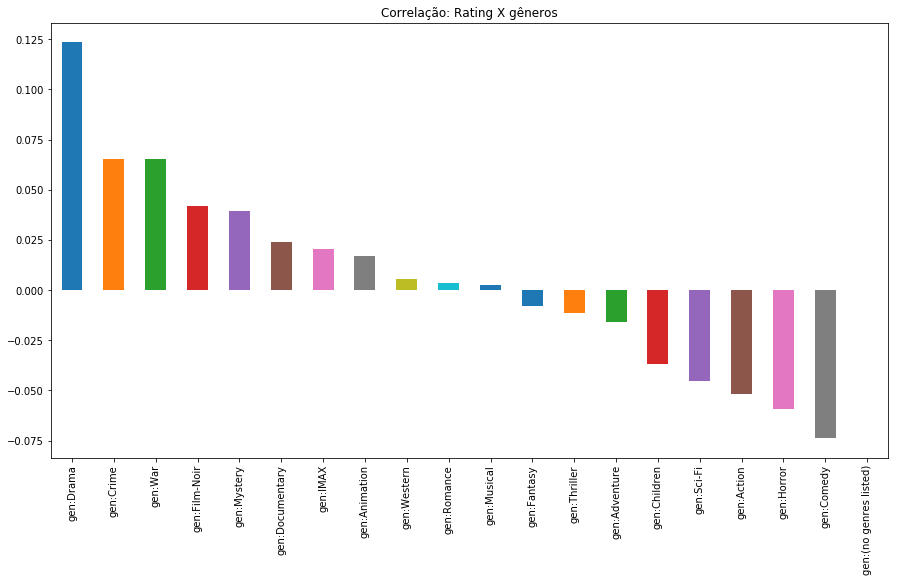

In [84]:
plt.figure(figsize=(15,8))
plt.title('Correlação: Rating X gêneros')
corr_pearson['rating'][gen_cols].sort_values(ascending=False).plot.bar();

Com os filmes retirados do dataframe não há mais contagens sem gênero, então podemos eliminar esta coluna.

O gênero "Drama" é o que apresenta maior correlação com a variável "rating" e mesmo sendo o maior apresenta uma correlação baixa. Isso indica que um sistema de recomendação baseado apenas no gênero dificilmente resultaria em avaliações altas. Em destaque os gêneros "Comedy" e "Horror" (há outros) apresentam correlação negativa indicando que filmes com estes gêneros tendem a não ser bem classificados.  Com isso podemos perceber que "Drama", "War", "Crime", e "Film-Noir" são gêneros com maior correlação com "rating" e este fato pode ser explicado. Tais gêneros são geralmente considerados mais cultos e há maior investimento e qualidade na feitura dos mesmos, resultando em avaliações melhores e também no maior número de avaliações do gênero Drama.
Entretanto, estressamos que estes valores de correlação são pequenos e nenhuma decisão deve ser baseada unicamente neste parâmetro.

#### Existe correlação entre os gêneros de filme?

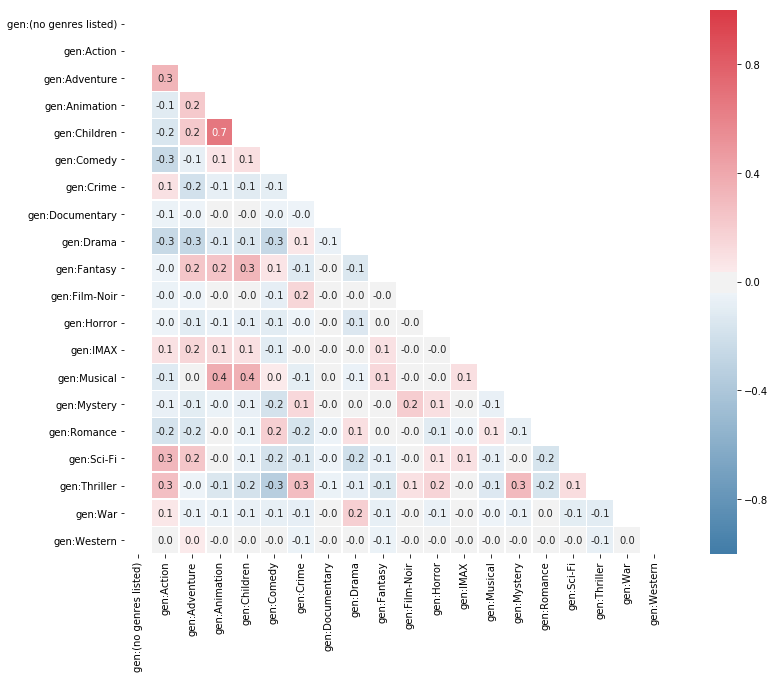

In [85]:
corr_map = corr_pearson.loc[gen_cols, gen_cols]
mask = np.zeros_like(corr_map)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(15, 10))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
grid = sns.heatmap(corr_map, mask=mask, square=True, annot=True, fmt='.1f', cmap=cmap, vmin=-1, center=0, linewidths=.5)

In [86]:
# definir gêneros similares pela correlação de pearson
def gen_similar(genero):
    print('Filmes do gênero',genero,'são similares a:')
    return corr_pearson['gen:'+genero][gen_cols].sort_values(ascending=False)[1:4]

In [87]:
gen_similar('Comedy')

Filmes do gênero Comedy são similares a:


gen:Romance     0.194479
gen:Children    0.107541
gen:Fantasy     0.078090
Name: gen:Comedy, dtype: float64

Usualmente uma correlação é considerada "forte" ou "alta" quando é maior que |0.5|. Podemos usar o contexto do problema para entender isto:
-  Os gêneros "Children" e "Animation" são os únicos que tem correlação maior que 0.5, isto faz sentido já que a maior parte do conteúdo infantil é também uma animação. Vamos então considerar que estes gêneros representam categorias diferentes para o caso de uma recomendação por gênero;
-  "Musical" apresenta correlação igual a 0.4 com  "Children" e "Animation". Vários musicais são também uma animação, entretanto se assumirmos que podemos descartar o gênero "Musical" um usuário que gosta deste gênero receberia muitas sugestões que não são musicais.

A decisão de descartar ou não um gênero é importante para o modelo e deve ser discutida e analisada com cuidado. Aqui decidimos excluir nenhum gênero baseado no fato de que todas as correlações são pequenas. Poderíamos ainda pensar que todos os filmes que pertenceriam a uma categoria chamada "Anime" teriam dificuldades em serem sugeridos e portanto "Animation" deveria continuar como um gênero válido.

#### A hora do dia influencia na avaliação que o usuário dá para um filme?

Text(0.5, 0, 'Hora da avaliação')

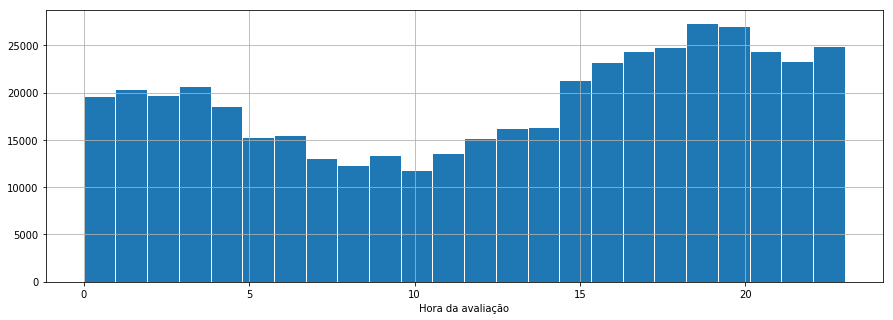

In [88]:
data['hour'].hist(edgecolor='w', figsize=(15,5), bins=24)
plt.xlabel('Hora da avaliação')

Não faz sentido verificar se existe correlação entre "rating" e "hour", pois não existe uma relação linear entre eles neste contexto. Neste caso o que pode ser feito é, assim como para os gêneros, criar uma matrix esparsa binária para as horas e assim calcular a correlação de Pearson. Outra coisa é utilizar a correlação de Spearman, pois ela não assume linearidade entre as variáveis.

A ideia é verificar se há uma hora específica em que os usuários são menos rigorosos na sua avaliação. Este entendimento traria uma opção de ação diferenciada na sugestão, por exemplo: Supomos que identificamos que os usuários costumam avaliar melhor um produto por volta de 22h. Isto significa que neste momento estão menos rigorosos e portanto mais abertos a sugestões de produtos novos. Com isso um cliente poderia pagar para que um produto novo fosse sugerido neste horário facilitando a aceitação do mesmo.

Outra característica do usuário que pode ser entendida com "hour" é identificar qual pessoa de uma família está utilizando o serviço, por exemplo: Um criança pode utilizar o serviço durante a manhã e os pais a noite. Novamente, produtos mais personalizados podem ser sugeridos.

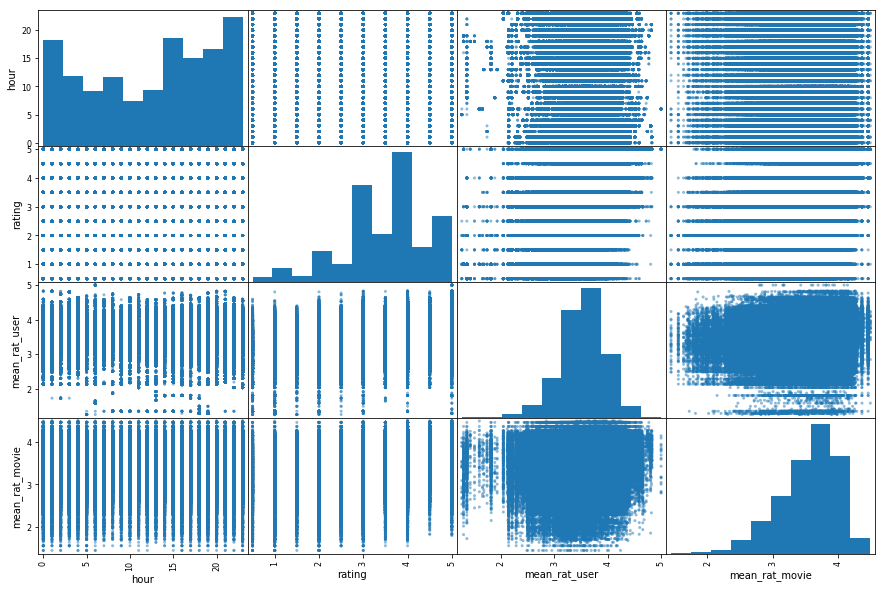

In [89]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['hour','rating','mean_rat_user','mean_rat_movie']], figsize=(15,10));

#### Hora da avaliação e contagem de gêneros

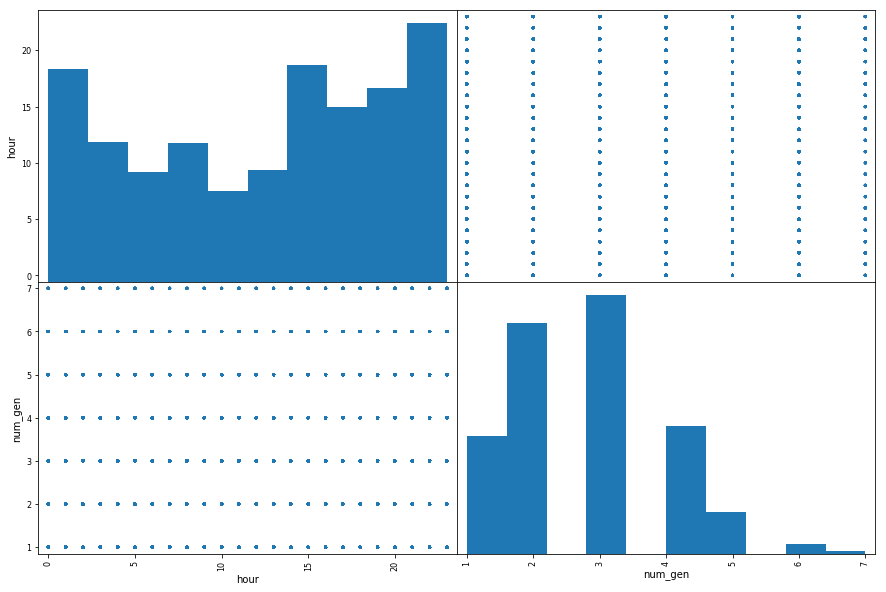

In [90]:
scatter_matrix(data[['hour','num_gen']], figsize=(15,10));

#### O ano de lançamento do filme influencia na avaliação?

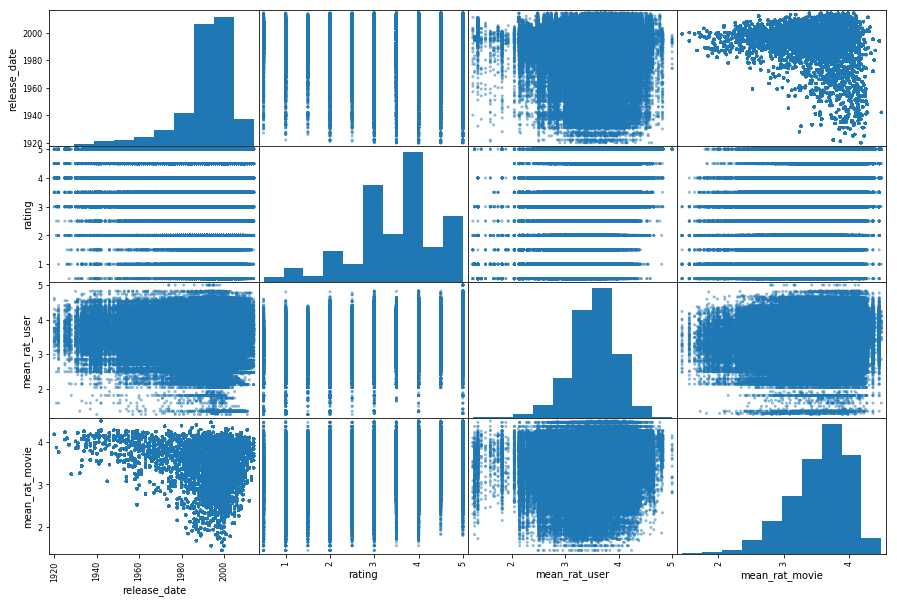

In [91]:
scatter_matrix(data[['release_date','rating','mean_rat_user','mean_rat_movie']], figsize=(15,10));

#### Variedade de gênero e ano de lançamento

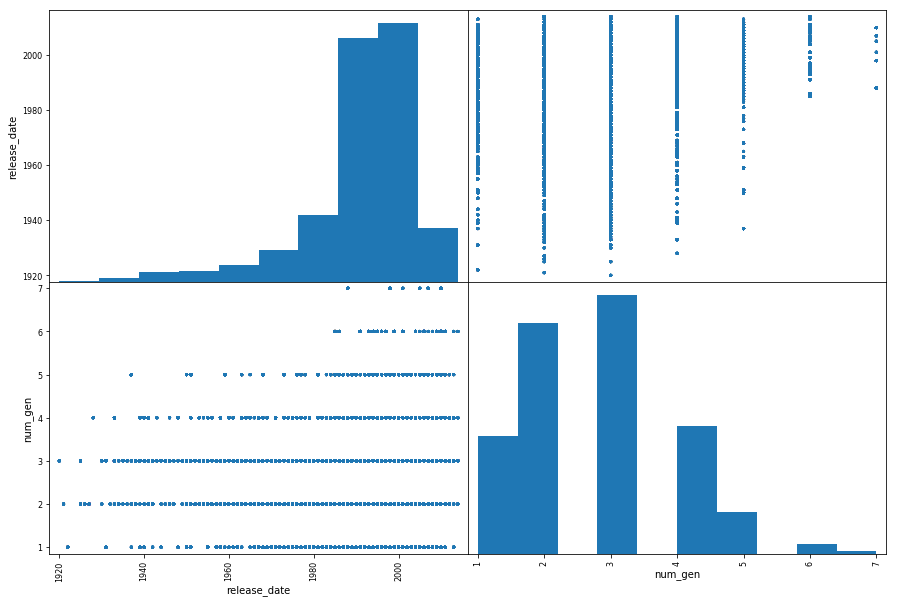

In [92]:
scatter_matrix(data[['release_date','num_gen']], figsize=(15,10));

In [93]:
corr_pearson['release_date']['num_gen']

0.06914352387774413

É comum que um usuário goste mais de filmes de um período específico: isso até pode ser visto no dataframe "dt_tags", no qual várias tags se referem ao ano; ou mesmo pela nostalgia que parece ser cada vez mais evidente. O Netflix identificou que séries focadas nos anos 80 são bem vistas pelos usuários, já séries focadas nos anos 90 parecem não ter tanto apelo.

#### Existe correlação entre variedade de gênero de um filme e sua avaliação?

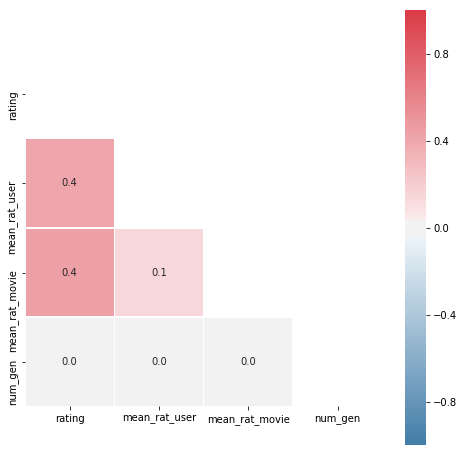

In [94]:
corr_map = corr_pearson.loc[['rating','mean_rat_user','mean_rat_movie','num_gen'], ['rating','mean_rat_user','mean_rat_movie','num_gen']]
mask = np.zeros_like(corr_map)
mask[np.triu_indices_from(mask)] = True
plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)
grid = sns.heatmap(corr_map, mask=mask, square=True, annot=True, fmt='.1f', cmap=cmap, vmin=-1, center=0, linewidths=.5)

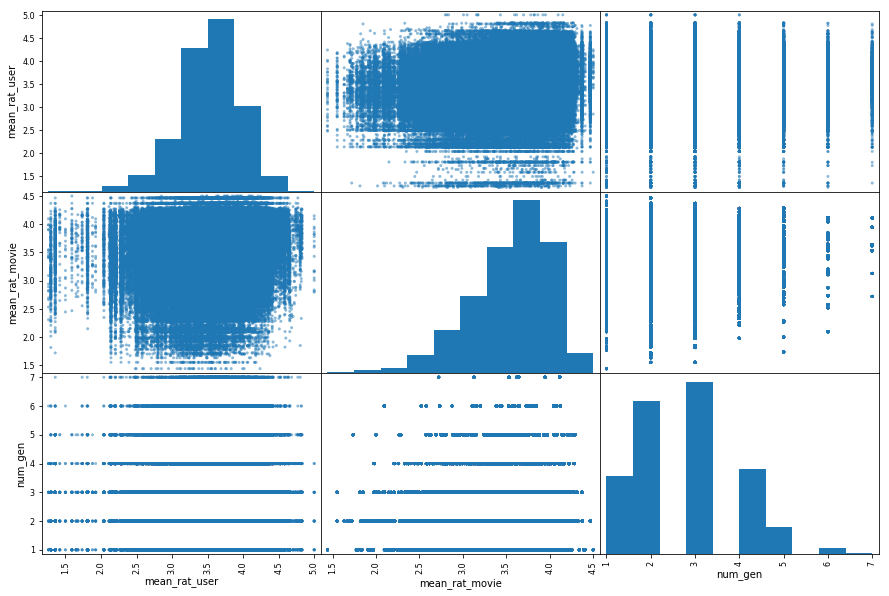

In [95]:
scatter_matrix(data[['mean_rat_user','mean_rat_movie','num_gen']], figsize=(15,10));

A correlação é pequena, talvez a relação não seja linear e tenha um número ótimo de categorias. Assim como no caso da hora e do ano de lançamento.

### Salvando o dataset final

In [96]:
data.to_csv(r'movie_dataset.csv',index=False)

# Parte 2 - Sistema de Recomendação  

Vamos então construir o sistema de recomendação utilizando as características definidas na seção anterior: gênero, ano de lançamento, rating, rating médio por usuário e rating médio por filme.

**Objetivo principal**: a partir do id do usuário recomendar cinco filmes baseado nas preferências de filme e gênero do usuário.

**Método**: utilizar as características dos filmes para treinar um algoritmo não supervisionado que identifique filme similares.

In [97]:
data.shape

(462919, 29)

In [98]:
# X = dataset que será utilizado para o treino do algoritmo com apenas as características dos filmes consideradas
X = data.drop_duplicates(subset='movieId')
X = X.reset_index(drop=True)

# dataset no qual os filmes serão procurados
X2 = X.copy()

In [99]:
X = X.drop(['movieId','title','hour','userId','rating','mean_rat_user','gen:(no genres listed)'],axis=1)
X.head(10)

,release_date,gen:Action,gen:Adventure,gen:Animation,gen:Children,gen:Comedy,gen:Crime,gen:Documentary,gen:Drama,gen:Fantasy,...,gen:IMAX,gen:Musical,gen:Mystery,gen:Romance,gen:Sci-Fi,gen:Thriller,gen:War,gen:Western,num_gen,mean_rat_movie
0,1995.0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,5,3.970998
1,1995.0,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,3,3.287346
2,1995.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,2,3.175926
3,1995.0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,3,3.110169
4,1995.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.154762
5,1995.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,3,3.833333
6,1995.0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,2,3.393519
7,1995.0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,3.175000
8,1995.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,3.093458
9,1995.0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,3,3.423423


**Obs:** A feature 'num_gen' não havia sido incluída inicialmente, mas após feita toda a análise um teste mostrou que a inclusão desta melhora o desempenho das recomendações.

### Breve análise com diferentes Scalers

In [100]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer,\
                                                QuantileTransformer, minmax_scale
# scalers list
scl = [MinMaxScaler(),StandardScaler(),MaxAbsScaler(),RobustScaler(quantile_range=(25, 75)),\
       QuantileTransformer(output_distribution='normal'),QuantileTransformer(output_distribution='uniform'),\
      Normalizer()]

/home/ninja/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


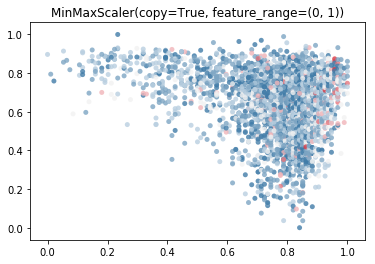

/home/ninja/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ninja/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


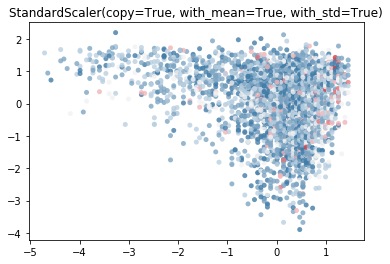

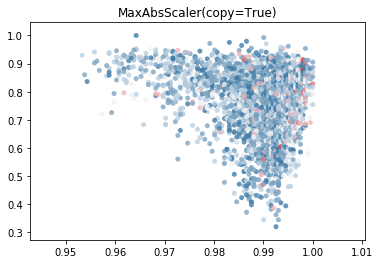

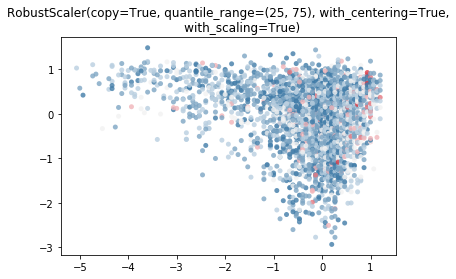

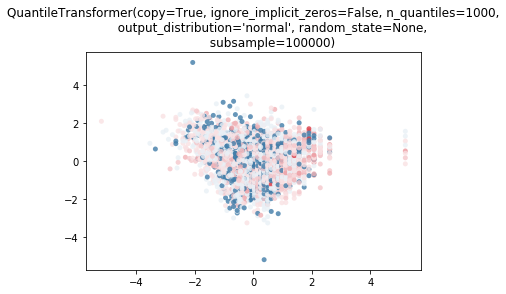

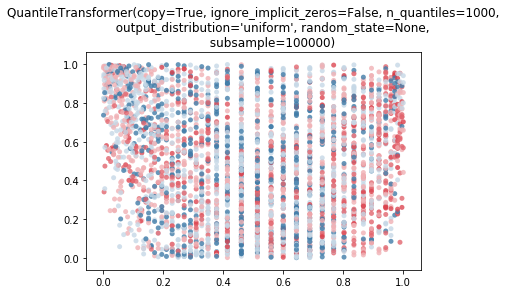

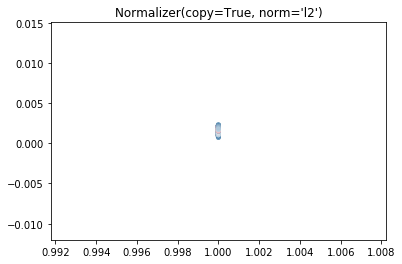

In [101]:
# exemplo
for item in scl:
    Xsc = item.fit_transform(X)
    y = minmax_scale(Xsc[:,-2])
    colors = cmap(y)
    plt.title(item)
    plt.scatter(Xsc[:,0],Xsc[:,-1],alpha=0.8, marker='o', s=25, lw=0,c=colors)
    plt.show()

/home/ninja/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ninja/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


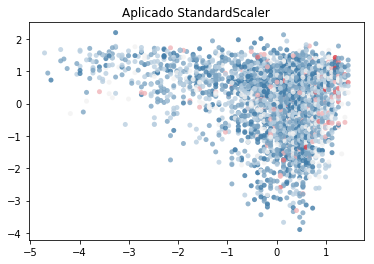

In [102]:
Xsc = StandardScaler().fit_transform(X)
y = minmax_scale(Xsc[:,-2])
colors = cmap(y)
plt.title('Aplicado StandardScaler')
plt.scatter(Xsc[:,0],Xsc[:,-1],alpha=0.8, marker='o', s=25, lw=0,c=colors)

/home/ninja/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ninja/.local/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


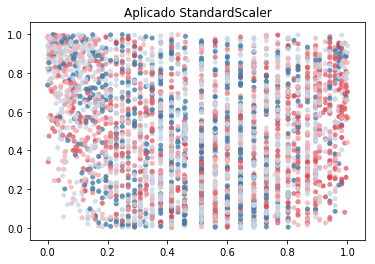

In [103]:
Xsc = QuantileTransformer(output_distribution='uniform').fit_transform(StandardScaler().fit_transform(X))
y = minmax_scale(Xsc[:,-2])
colors = cmap(y)
plt.title('Aplicado StandardScaler')
plt.scatter(Xsc[:,0],Xsc[:,-1],alpha=0.8, marker='o', s=25, lw=0,c=colors)

Observemos que para as fetures não binárias como 'release_date' e 'mean_rat_movie' a separação dos datapoints feita por 'QuantileTransformer(output_distribution='uniform')' ajuda a tornar o cálculo da distância entre os vizinhos mais coerente, pois torna a distribuição de datapoints mais homogênea, enquanto não afeta as features binárias. Já o StandardScaler tem efeito sobre as features binárias. Portanto, a aplicação destas duas funções possivelmente é a mais adequada ao problema.

### Treino não-supervisionado: NearestNeighbors

In [104]:
Xsc = QuantileTransformer(output_distribution='uniform').fit_transform(X)

from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=4,algorithm='ball_tree').fit(Xsc)

In [105]:
distances, indices = knn.kneighbors(Xsc,n_neighbors=len(X2['movieId']))

### Funções para as recomendações

In [106]:
# encontra o índice de um filme no dtaframe X2 a partir do título
def movie_index_title(title):
    return X2[X2['title']==title].index.tolist()[0]

In [107]:
movie_index_title('Jumanji (1995)')

1

In [108]:
# identifica os três gêneros favoritos do usuário
def gen_fav(userId):
    gen_cols = ['gen:(no genres listed)','gen:Action','gen:Adventure','gen:Animation','gen:Children','gen:Comedy','gen:Crime',
                'gen:Documentary','gen:Drama','gen:Fantasy','gen:Film-Noir','gen:Horror','gen:IMAX','gen:Musical','gen:Mystery',
                'gen:Romance', 'gen:Sci-Fi','gen:Thriller','gen:War','gen:Western']
    gen_corr = data[data['userId']==userId].corr(method='pearson')
    return gen_corr['rating'][gen_cols].sort_values(ascending=False).index[:3]

In [109]:
gen_fav(1)

Index(['gen:Romance', 'gen:Fantasy', 'gen:IMAX'], dtype='object')

In [110]:
# retorna o movieId do filme favorito de um usuário escolhido e de um gênero escolhido
def movieId_fav(userId,genre):
    return data[data['userId']==userId].sort_values(by=[genre,'rating','mean_rat_movie'],\
                                                    ascending=[False,False,False])['movieId'].values[0]

In [111]:
movieId_fav(1,gen_fav(1)[0])

3996

In [112]:
# retorna o title do filme favorito de um um gênero escolhido
def title_fav(userId,genre):
    return data[data['userId']==userId].sort_values(by=[genre,'rating','mean_rat_movie'],\
                                                    ascending=[False,False,False])['title'].iloc[0]

In [113]:
title_fav(1,gen_fav(1)[0])

'Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'

In [114]:
# set é usado pra listar apenas itens não repetidos
all_movie_titles = list(set(data['title'].values))

def movie_from_partial_title(partial):
    partial = partial.lower()
    for title in all_movie_titles:
        if partial in title.lower():
            print(title,all_movie_titles.index(title))

In [115]:
movie_from_partial_title('star')

Superstar (1999) 129
Star Trek: Nemesis (2002) 135
Last Starfighter, The (1984) 192
Battlestar Galactica (2003) 220
Star Wars: Episode IV - A New Hope (1977) 272
Star Trek (2009) 277
Starman (1984) 454
Starsky & Hutch (2004) 490
Startup.com (2001) 536
Starship Troopers (1997) 543
Battlestar Galactica: Razor (2007) 551
Stargate (1994) 660
Star Wars: Episode III - Revenge of the Sith (2005) 755
Star Trek VI: The Undiscovered Country (1991) 784
Star Trek IV: The Voyage Home (1986) 954
Men Who Stare at Goats, The (2009) 1061
Firestarter (1984) 1142
Star Trek III: The Search for Spock (1984) 1191
Star Wars: Episode V - The Empire Strikes Back (1980) 1326
Lone Star (1996) 1424
Stardust (2007) 1517
Star Trek: Insurrection (1998) 1620
Star Trek: First Contact (1996) 1711
Star Wars: Episode I - The Phantom Menace (1999) 1870
Star Trek V: The Final Frontier (1989) 2107
Rock Star (2001) 2110
Star Trek: Generations (1994) 2223
Star Wars: Episode VI - Return of the Jedi (1983) 2603
Star Trek: The M

In [116]:
# recomenda três filmes para cada um dos gêneros favoritos do usuário

''' lembrar de considerar os casos em que não há filme disponível'''

def recom_movie(userId):
    gen_list = gen_fav(userId)
    for item in gen_list:
        id = X2[X2['movieId']==int(movieId_fav(userId,item))].index.tolist()[0]
        print('Baseado no seu gosto por',item,'veja:\n')
        for id in indices[id][1:6]:
            print(X2.loc[id]['title'])
        print('')

In [117]:
recom_movie(1)

Baseado no seu gosto por gen:Romance veja:

House of Flying Daggers (Shi mian mai fu) (2004)
First Knight (1995)
Days of Thunder (1990)
Beautiful Mind, A (2001)
In America (2002)

Baseado no seu gosto por gen:Fantasy veja:

Fall, The (2006)
Into the Wild (2007)
Princess Mononoke (Mononoke-hime) (1997)
Gladiator (2000)
Hero (Ying xiong) (2002)

Baseado no seu gosto por gen:IMAX veja:

Tron: Legacy (2010)
Pacific Rim (2013)
Captain America: The Winter Soldier (2014)
Amazing Spider-Man, The (2012)
Transformers: Revenge of the Fallen (2009)



In [118]:
# fornece uma lista com o movieId de 10 filmes recomendados ao usuário
def recom_movieId(userId):
    movie_list = []
    gen = gen_fav(userId)[0]
    id = X2[X2['movieId']==int(movieId_fav(userId,gen))].index.tolist()[0]
    for id in indices[id][1:11]:
        movie_list.append(X2.loc[id]['movieId'])
    return movie_list

In [119]:
recom_movieId(1)

[8983, 168, 1100, 4995, 7139, 5225, 5812, 7034, 2443, 5791]

# Parte 3 - Avaliação do sistema de recomendação

Para avaliar o sistema de recomendação contruído não cabem as métricas usuais de classificação (accuracy, precision, F1, Recall e Confusion Matrix) e regressão (R2, RMSE, MAE e Explained Variance). De qualquer forma precisamos de uma forma de avaliá-lo.

Uma maneira seria fazer um teste AB: se um grupo de usuários avaliar positivamente os filmes sugeridos teríamos um indicativo de sucesso nas sugestões, mas não há como fazer isso durante esse problema. Vamos então utilizar uma métrica qualitativa e discutir sobre outra quantitativa.

### Métrica qualitativa

Vamos criar uma lista de filmes favoritos de determinado gênero de um usuário bem como uma lista de sugestões. Desta forma verificamos quantos dos filmes sugeridos estão na lista de favoritos, cada sugestão que atender esta especificação será considerada um sucesso. Por fim, contamos o número de sucessos totais depois de n recomendações para m usuários. Chamamos de métrica qualitativa pois não se encaixa em um padrão bem estabelecido e o tamanho das listas é não-definido. Se a lista de favoritos for grande, da ordem do número de filmes avaliados, invariavelmente obteremos sucesso na recomendação.

A partir disso poderíamos criar uma maneira de utilizar as métricas de classificação como segue abaixo:

| Classificação | Condição      | 
| ------------- |:-------------:|
| TP            | $A \in B$     |
| FP            | $A \notin B$  |
| TN            | $X \setminus{A} \notin B$|
| FN            | $X \setminus{A} \notin B$|

onde A são os filmes sugeridos, B os filmes favoritos e X todos os filmes. Para não fugir do objetivo, vamos usar apenas a ideia dos sucessos.

### Métrica quantitativa

Dadas as listas de filmes favoritos e sugeridos, é possível utilizar o método *kneighbors* para obter as distâncias entre dois datapoints ou a distância média entre as listas. Nesse caso quanto menor a distância média, melhores são as sugestões.


Sugestão de referência: https://frnsys.com/ai_notes/machine_learning/unsupervised_learning.html

### Medindo os sucessos

Definimos uma função chamada overall_sucess(num_users) que atribui aos primeiros n_users usuários de X2 o número de sucessos totais obtidos sugerindo 10 filmes e verificando quantos destes estão na lista de 10 favoritos de cada usuário.

Para determinar os 10 filmes favoritos utilizamos um filtro considerando a ordem: gênero favorito, rating o usuário e rating médio do filme.

É importante lembrar que é possível que com esse filtro não haja 10 filmes na lista, mas não vamos nos preocupar com isso.

A função user_sucess(userId) tem o mesmo papel da função anterior, porém dando o número de sucessos de um usuário escolhido.

In [120]:
def overall_sucess(num_users):
    sucess=0
    for userId in range(1,num_users):
        rated_movies = data[data['userId']==userId].sort_values(by=[gen_fav(userId)[0],'rating','mean_rat_movie'],\
                                                    ascending=[False,False,False])
        sucess = sucess + rated_movies['movieId'].iloc[:10].isin(recom_movieId(userId)).sum()
    return sucess

In [121]:
def user_sucess(userId):
    sucess=0
    rated_movies = data[data['userId']==userId].sort_values(by=[gen_fav(userId)[0],'rating','mean_rat_movie'],\
                                                    ascending=[False,False,False])
    sucess = sucess + rated_movies['movieId'].iloc[:10].isin(recom_movieId(userId)).sum()
    return sucess

In [122]:
overall_sucess(100)

53

In [123]:
user_sucess(1)

0

In [124]:
user_sucess(2)

2

Observamos que para recomendações para os 100 primeiros usuários obtivemos 46 sucessos. Esta é uma medida qualitativa como discutimos anteriormente, mas vamos utilizá-la como base para buscar parâmetros que melhorem o desemprenho da recomendação.

Em testes usando o scaler 'MinMaxScaler' foram obtidos 46 sucessos.

#### Recomendações ao acaso

Podemos entender se o valor de sucessos obtido nas recomendações é bom ou não comparando com recomendações ao acaso. Temos um conjunto M de 27278 filmes, destes vamos escolher 10 aleatoriamente e comparar quantos sucessos temos. Este tipo de experimento se encaixa em uma distribuição do tipo hipergeométrica. Vejamos:

Sejam M=27278 o conjunto dos filmes, N=10 o número de filmes favoritos que pertencem a M, n=10 o tamanho do subconjunto de filmes que escolhemos aleatoriamente e x o número de sucessos dentro de n, ou seja, o número de filmes em n que coincide com os 10 filmes favoritos do usuário.

Utilizamos a função hypergeom da biblioteca scipy temos:

In [125]:
from scipy.stats import hypergeom
import numpy as np

[M, n, N] = [27278, 10, 10]
rv = hypergeom(M, n, N)
x = np.arange(0, n+1)
pmf_movies = rv.pmf(x)

In [126]:
print('Resultados para recomendações aleatórias para 1 usuário:')
print('Probabilidade de se obter um sucesso:{:.5f}'.format(rv.pmf(1)))
print('Número de sucessos esperado:{:.5f}'.format(rv.expect()))
print('Média:{:.5f}'.format(rv.mean()))
print('Variância:{:.5f}'.format(rv.var()))
print('Desvio padrão:{:.5f}'.format(rv.std()))

Resultados para recomendações aleatórias para 1 usuário:
Probabilidade de se obter um sucesso:0.00366
Número de sucessos esperado:0.00367
Média:0.00367
Variância:0.00366
Desvio padrão:0.06053


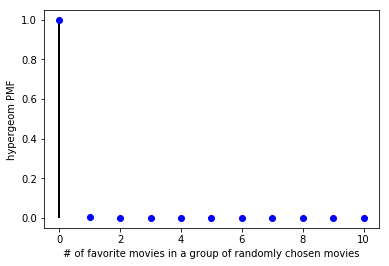

In [127]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, pmf_movies, 'bo')
ax.vlines(x, 0, pmf_movies, lw=2)
ax.set_xlabel('# of favorite movies in a group of randomly chosen movies')
ax.set_ylabel('hypergeom PMF')
plt.show()

Para o resultado obtido pelo sistema de recomendação, dividimos 53 por 100 e obtemos 0.53 sucessos por usuário (ou por experimento), enquanto o valor esperado para a distribuição acima para um usuário é 0.00367, ou seja, **o sistema de recomendação criado tem capacidade de sucesso 144 maior que uma recomendação ao acaso**.

Como não possuímos outro sistema de recomendação para fazer a comparação este resultado seria suficiente para a implementação do sistema criado aqui.

In [128]:
0.53/0.00367

144.4141689373297

### Fine-tuninnig

Para melhorar o desempenho das recomendações vamos usar como parâmetro o número de sucessos nos primeiros 100 usuários sugerindo 10 filmes para cada um e a partir disso modificar os parâmetros do algorimo:

Quatro parâmetros do algoritmo NearestNeighbors serão testados:  

-  Número de vizinho: este número não pode ser muito grande, pois pode acabar generalizando a similaridade entre os filmes;
-  Algoritmo: os quatro algoritmos disponíveis 'auto', 'ball_tree','kd_tree' e 'brute' serão testados. Cada um possui algumas características diferentes na determinação os vizinhos de cada datapoint;
-  Tamanho de folhas: característica utilizada por 'ball_tree' e 'kd_tree';
-  Métricas: usaremos todas as métricas disponíveis parara determinar distâncias entre os datapoints: 'cityblock','cosine','euclidean' e 'minkowski'. Para um melhor entendimento de qual é o mais adequado ao caso é necessário mais tempo analisando o próprio espaço que contem o dataset X.

Vamos dividir em duas etapa:

In [130]:
import time
start = time.time()

results = pd.DataFrame({'neighbors':[],'algorithm':[],'leaf_size':[],'sucess':[]})
for neigh in [4,7,10,15]:
    for alg in ['auto', 'ball_tree','kd_tree', 'brute']:
        for n_leaves in [20,30,40]:
            knn = NearestNeighbors(n_neighbors=neigh,algorithm=alg,leaf_size=n_leaves).fit(Xsc)
            distances, indices = knn.kneighbors(Xsc,n_neighbors=len(X2['movieId']))
            new_result = pd.DataFrame({'neighbors':[neigh],'algorithm':[alg],'leaf_size':[n_leaves],'sucess':[overall_sucess(100)]})
            results = pd.concat([results,new_result],axis=0)

print((time.time()-start)/60,'min.')

1.722077480951945 min.


In [131]:
results.sort_values(by='sucess',ascending=False).head(15)

,neighbors,algorithm,leaf_size,sucess
0,4.0,auto,20.0,53.0
0,4.0,auto,30.0,53.0
0,10.0,auto,40.0,53.0
0,10.0,ball_tree,20.0,53.0
0,10.0,ball_tree,30.0,53.0
0,10.0,ball_tree,40.0,53.0
0,10.0,kd_tree,20.0,53.0
0,10.0,kd_tree,30.0,53.0
0,10.0,kd_tree,40.0,53.0
0,10.0,brute,20.0,53.0


In [132]:
results['sucess'].unique()

array([53.])

Em testes usando o scaler 'MinMaxScaler' foram obtidos 46 sucessos.

In [133]:
start = time.time()

results = pd.DataFrame({'neighbors':[],'algorithm':[],'leaf_size':[],'metric':[],'sucess':[]})
for neigh in [4,7,10,15]:
    for n_leaves in [20,30,40]:
        for metrics in ['cityblock','cosine','euclidean','minkowski']:
            knn = NearestNeighbors(n_neighbors=neigh,algorithm='auto',leaf_size=n_leaves,metric=metrics).fit(Xsc)
            distances, indices = knn.kneighbors(Xsc,n_neighbors=len(X2['movieId']))
            new_result = pd.DataFrame({'neighbors':[neigh],'algorithm':[alg],'leaf_size':[n_leaves],'metric':[metrics],'sucess':[overall_sucess(100)]})
            results = pd.concat([results,new_result],axis=0)

print((time.time()-start)/60,'min.')

1.7523009339968363 min.


In [134]:
results.sort_values(by='sucess',ascending=False).head(15)

,neighbors,algorithm,leaf_size,metric,sucess
0,4.0,brute,20.0,cityblock,61.0
0,7.0,brute,20.0,cityblock,61.0
0,15.0,brute,40.0,cityblock,61.0
0,15.0,brute,30.0,cityblock,61.0
0,15.0,brute,20.0,cityblock,61.0
0,10.0,brute,40.0,cityblock,61.0
0,10.0,brute,30.0,cityblock,61.0
0,7.0,brute,40.0,cityblock,61.0
0,7.0,brute,30.0,cityblock,61.0
0,10.0,brute,20.0,cityblock,61.0


In [135]:
results['sucess'].unique()

array([61., 55., 53.])

Houve algum aumento no número de sucessos, de 53 para 61, que se comparado as recomendações ao acaso temos uma chance de sucesso 169 vezes maior utilizando a métrica 'cosine'. Desta forma poderíamos escolher os parâmetros que utilizam um tempo de computação menor, como 4 vizinhos e leaf_size igual a 20.

Em testes usando o scaler 'MinMaxScaler' foram obtidos 55 sucessos.

#### Usando QuantileTransformer(StandardScaler)

In [136]:
Xsc = QuantileTransformer(output_distribution='uniform').fit_transform(X)

In [137]:
start = time.time()

results = pd.DataFrame({'neighbors':[],'algorithm':[],'leaf_size':[],'metric':[],'sucess':[]})
for neigh in [4,7,10,15]:
    for n_leaves in [20,30,40]:
        for metrics in ['cityblock','cosine','euclidean','minkowski']:
            knn = NearestNeighbors(n_neighbors=neigh,algorithm='auto',leaf_size=n_leaves,metric=metrics).fit(Xsc)
            distances, indices = knn.kneighbors(Xsc,n_neighbors=len(X2['movieId']))
            new_result = pd.DataFrame({'neighbors':[neigh],'algorithm':[alg],'leaf_size':[n_leaves],'metric':[metrics],'sucess':[overall_sucess(100)]})
            results = pd.concat([results,new_result],axis=0)

print((time.time()-start)/60,'min.')

1.7522268255551656 min.


In [138]:
results.sort_values(by='sucess',ascending=False).head(25)

,neighbors,algorithm,leaf_size,metric,sucess
0,4.0,brute,20.0,cityblock,61.0
0,7.0,brute,20.0,cityblock,61.0
0,15.0,brute,40.0,cityblock,61.0
0,15.0,brute,30.0,cityblock,61.0
0,15.0,brute,20.0,cityblock,61.0
0,10.0,brute,40.0,cityblock,61.0
0,10.0,brute,30.0,cityblock,61.0
0,7.0,brute,40.0,cityblock,61.0
0,7.0,brute,30.0,cityblock,61.0
0,10.0,brute,20.0,cityblock,61.0


In [139]:
results['sucess'].unique()

array([61., 55., 53.])

# Conclusões

Vamos discutir vários aspectos do sistema de recomendação construído abordando suas falhas e possíveis melhorias.

#### Objetivo principal

O objetivo de recomendar filmes para o usuário através da entrada de seu userId foi cumprido e pode ser visto utilizando a função **recom_movie(userId)**. As sugestões são dadas na forma de cinco filmes para cada um dos três gêneros favoritos do usuário.

##### Sobre as features disponíveis

O link sugerido para acessar o dataset leva ao dataset chamado ml-20m e neste não há informações mais específicas sobre os usuários. Há um dataset menor, ml-100k, na mesma base que possui os dados de idade, gênero, profissão e endereço (zipcode) do usuário. Caso estas informações fossem utilizadas poderíamos encontrar filmes favoritos do usuário com um algoritmo, como o NearestNeighbors, para identificar filmes favoritos e utilizá-los como referência para filmes similares.

Outra característica que poderia ser utilizada neste algoritmo seria o 'timestamp', pois filmes vistos por último e com boa avaliação podem ser uma sugestão melhor que filmes vistos há muito tempo com boa avaliação.

Como o dataset ml-100k não foi indicado primariamente vamos assumir que não temos estes dados e utilizar a correlação de Pearson e entre o 'rating' e os gêneros para determinar os gêneros favoritos e utilizá-los para fazer a sugestão.

Aqui foram usadas variáveis pouco significativas para classificar um filme. Com mais informações como o país de origem, duração, língua, protagonistas e avaliação de sites como Rotten Tomatoes e IMDB enriqueceríamos a capacidade de encontrar semelhanças entre os filmes. Estes dados podem ser encontrados com a própria base de dados do IMDB e o dataset 'links' contém o Id de cada filme para fazer esta busca.

#### Métricas para ranqueamento e modelo escolhido

Foi escolhido um modelo que considera um espaço abstrato contendo como datapoints os filmes. A semelhança entre os filmes é determinada pela proximidade dos datapoints neste espaço, chamada de similaridade na matemática. O algoritmo utilizado, NearestNeighbors, utilizou como características (features) dos datapoints o ano de lançamento, os gêneros e a avaliação média dos usuários.

Poderíamos enriquecer muito as características dos filmes utilizando um pouco de Natural Language Processing para obter informações das palavras contidas nos datasets "tags", "genome_tags", "genome_scores" e também nos títulos dos filmes.

Um sistema com avaliação do tipo "like" e "dislike" permitiria a construção de um modelo de classificação, que permitiria usar as métricas convencionais (accuracy, precision, F1, Recall e Confusion Matrix) ao invés de uma métrica criada especificamente para esse problema, o número de sucessos.

Há diversas outras maneiras de realizar a recomendações, por exemplo, o sistema poderia ter como "target" prever a nota que o usuário daria para o filme e recomendar os filmes de acordo com as maiores avaliações previstas. A vantagem desse sistema é a fácil verificação de performance através de métricas como RMSE, além disso poderíamos separar o dataset em train set e test set para avalição entre outras coisas a generalização, ovefitting e underfitting.


#### Avaliação do modelo

O método escolhido dificultou a avaliação do modelo por não se encaixar nos padrões mais conhecidos, foi então estabelecida uma métrica qualitativa que conta quantas das recomendações estão entre os filmes favoritos de um usuário. Comparando os resultados obtidos com recomendações feitas ao acaso o sistema construído apresentou um número de sucessos 169 maior. Outro ponto que pode ter afetado o resultado das recomendações é o método escolhido para determinar os filmes favoritos do usuário, pois há grande chance de que todos os 10 filmes tenham recebido avaliação 5, assim o critério de desempate seria apenas a avaliação média do filme.